# Simple inversion
Here we will walkthrough a very simple gravity inversion using synthetic data. The goal of the inversion is to recover the geometry of a layer. In this case, the layer is simply the surface of the Earth, which is represented by the density contrast between air and rock.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import verde as vd
import xarray as xr
from antarctic_plots import maps
from antarctic_plots import utils as ap_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

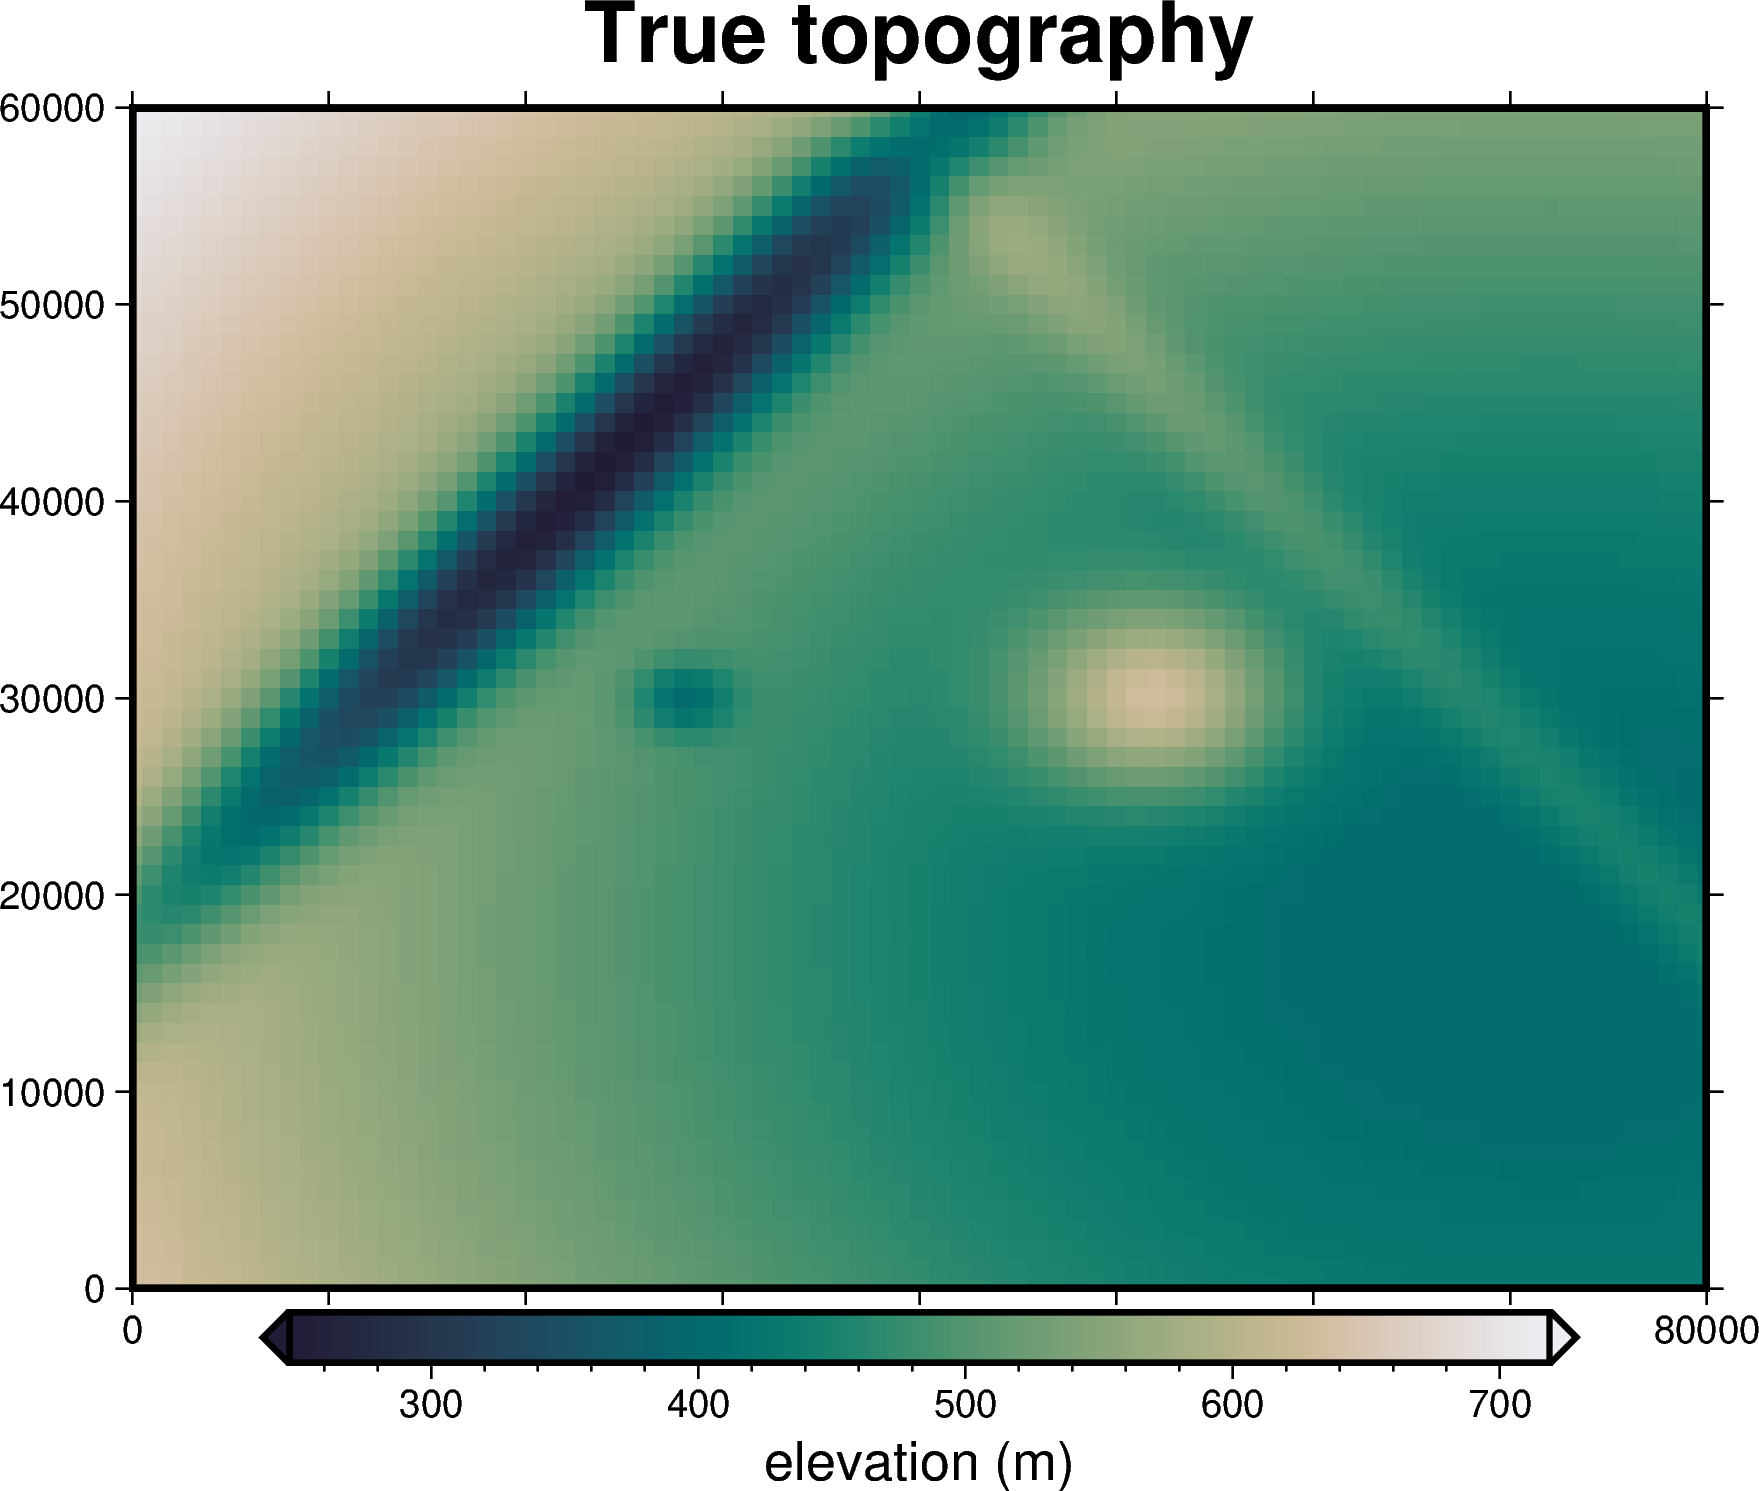

<xarray.DataArray 'upward' (northing: 61, easting: 81)>
array([[637.12943453, 632.19538446, 627.28784729, ..., 429.33158321,
        429.94283295, 430.64751872],
       [634.98693024, 630.03468543, 625.10864111, ..., 426.39921792,
        427.01279345, 427.72016051],
       [632.95724141, 627.98926162, 623.04617819, ..., 423.6241977 ,
        424.23997422, 424.94987872],
       ...,
       [709.90739328, 705.61112993, 701.33808009, ..., 528.97704204,
        529.50925875, 530.12283044],
       [714.19597392, 709.93730524, 705.70164695, ..., 534.84886306,
        535.37642258, 535.98462518],
       [718.55151946, 714.33103249, 710.13334959, ..., 540.8123708 ,
        541.33520041, 541.93795008]])
Coordinates:
  * easting   (easting) float64 0.0 1e+03 2e+03 3e+03 ... 7.8e+04 7.9e+04 8e+04
  * northing  (northing) float64 0.0 1e+03 2e+03 3e+03 ... 5.8e+04 5.9e+04 6e+04

In [2]:
# set grid parameters
spacing = 1000
region = [0, 80000, 0, 60000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=region,
)
fig.show()

true_topography

### Prism layer

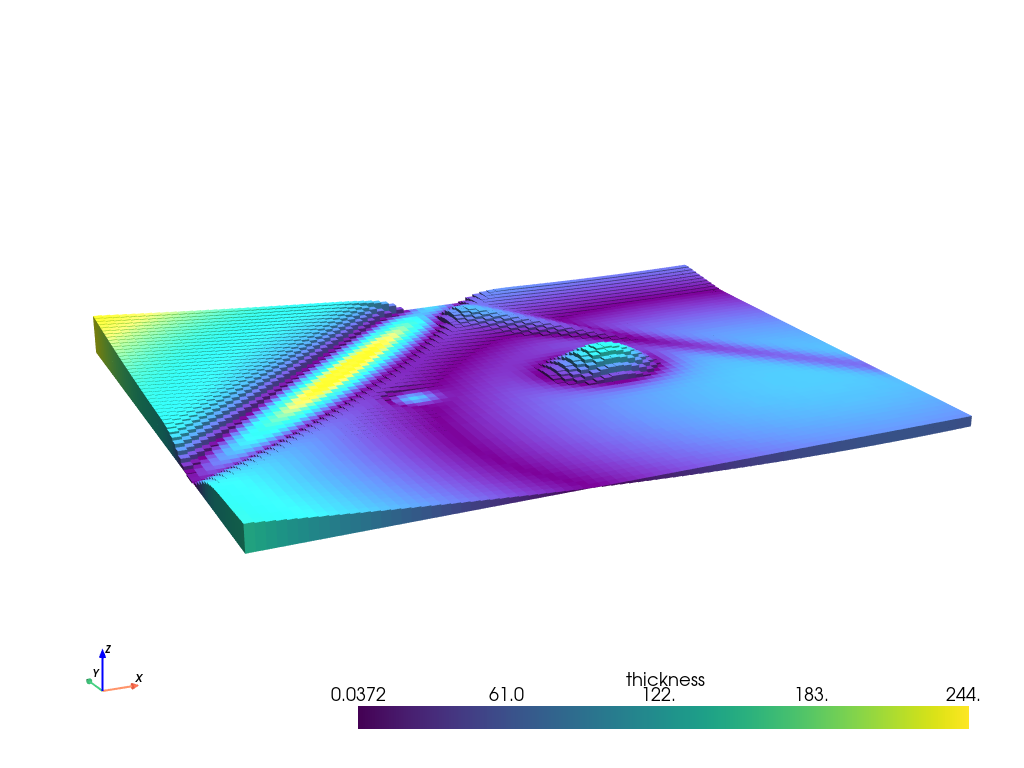

In [3]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

### Forward gravity of prism layer

In [4]:
# make pandas dataframe of locations to calculate gravity
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,9.841928
1,0.0,1000.0,1000.0,11.119944
2,0.0,2000.0,1000.0,11.057737
3,0.0,3000.0,1000.0,10.781017
4,0.0,4000.0,1000.0,10.437176
...,...,...,...,...
4936,60000.0,76000.0,1000.0,3.722437
4937,60000.0,77000.0,1000.0,3.730724
4938,60000.0,78000.0,1000.0,3.722855
4939,60000.0,79000.0,1000.0,3.647590


## Gravity misfit
Now we need to create a starting model of the topography, calculate it's forward gravity effect, and subtract it from our observed gravity to get a starting gravity misfit. In this simple case, our starting model will be flat, so it's forward gravity will be constant.  

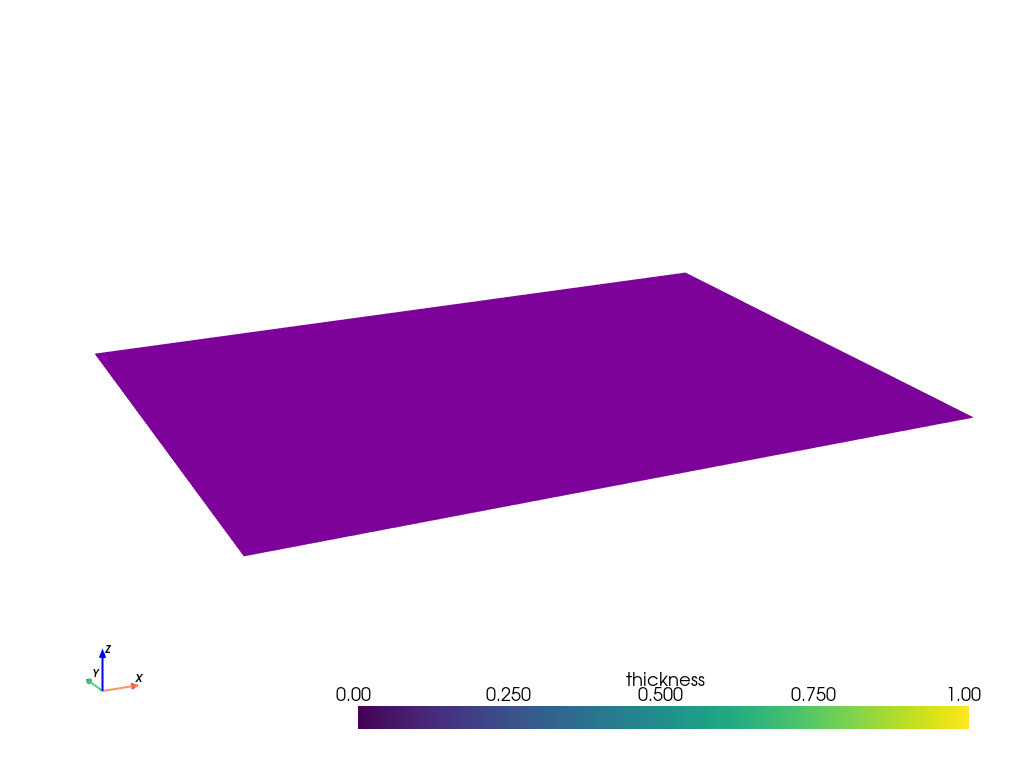

In [5]:
# create flat topography grid with a constant height of 500 m
starting_topography = xr.full_like(true_topography, 500)

# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between 500 m and the height of the topography, which for this
# starting model is flat at 500 m
zref = 500

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [6]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.841928,0.0,9.841928,0,9.841928
1,0.0,1000.0,1000.0,11.119944,0.0,11.119944,0,11.119944
2,0.0,2000.0,1000.0,11.057737,0.0,11.057737,0,11.057737
3,0.0,3000.0,1000.0,10.781017,0.0,10.781017,0,10.781017
4,0.0,4000.0,1000.0,10.437176,0.0,10.437176,0,10.437176
...,...,...,...,...,...,...,...,...
4936,60000.0,76000.0,1000.0,3.722437,0.0,3.722437,0,3.722437
4937,60000.0,77000.0,1000.0,3.730724,0.0,3.730724,0,3.730724
4938,60000.0,78000.0,1000.0,3.722855,0.0,3.722855,0,3.722855
4939,60000.0,79000.0,1000.0,3.647590,0.0,3.647590,0,3.647590


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

INFO:root:starting inversion
INFO:root:extracted zref is 500.0
INFO:root:extracted prism spacing is 1000.0
INFO:root:extracted density contrast is 2669
INFO:root:
 #################################### 
 iteration 1
INFO:numba.core.transforms:finding looplift candidates
INFO:root:Layer correction median: -9.1476 m, RMSE:78.8864 m
INFO:root:updated misfit RMSE: 0.1822
INFO:root:updated L2-norm: 0.4268, tolerance: 0.02
INFO:root:updated delta L2-norm : 6.5396, tolerance: 1.001
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 0.0244 m, RMSE:2.2313 m
INFO:root:updated misfit RMSE: 0.0124
INFO:root:updated L2-norm: 0.1115, tolerance: 0.02
INFO:root:updated delta L2-norm : 3.8279, tolerance: 1.001
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 0.0008 m, RMSE:0.1843 m
INFO:root:updated misfit RMSE: 0.002
INFO:root:updated L2-norm: 0.0446, tolerance: 0.02
INFO:root:updated delta L2-norm : 2.5026,

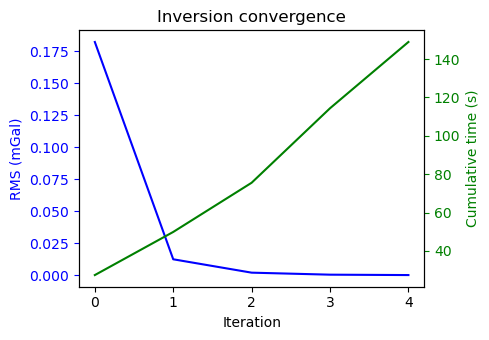

In [7]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="prisms",
    # set stopping criteria
    max_iterations=10,
    l2_norm_tolerance=0.02,
    delta_l2_norm_tolerance=1.001,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


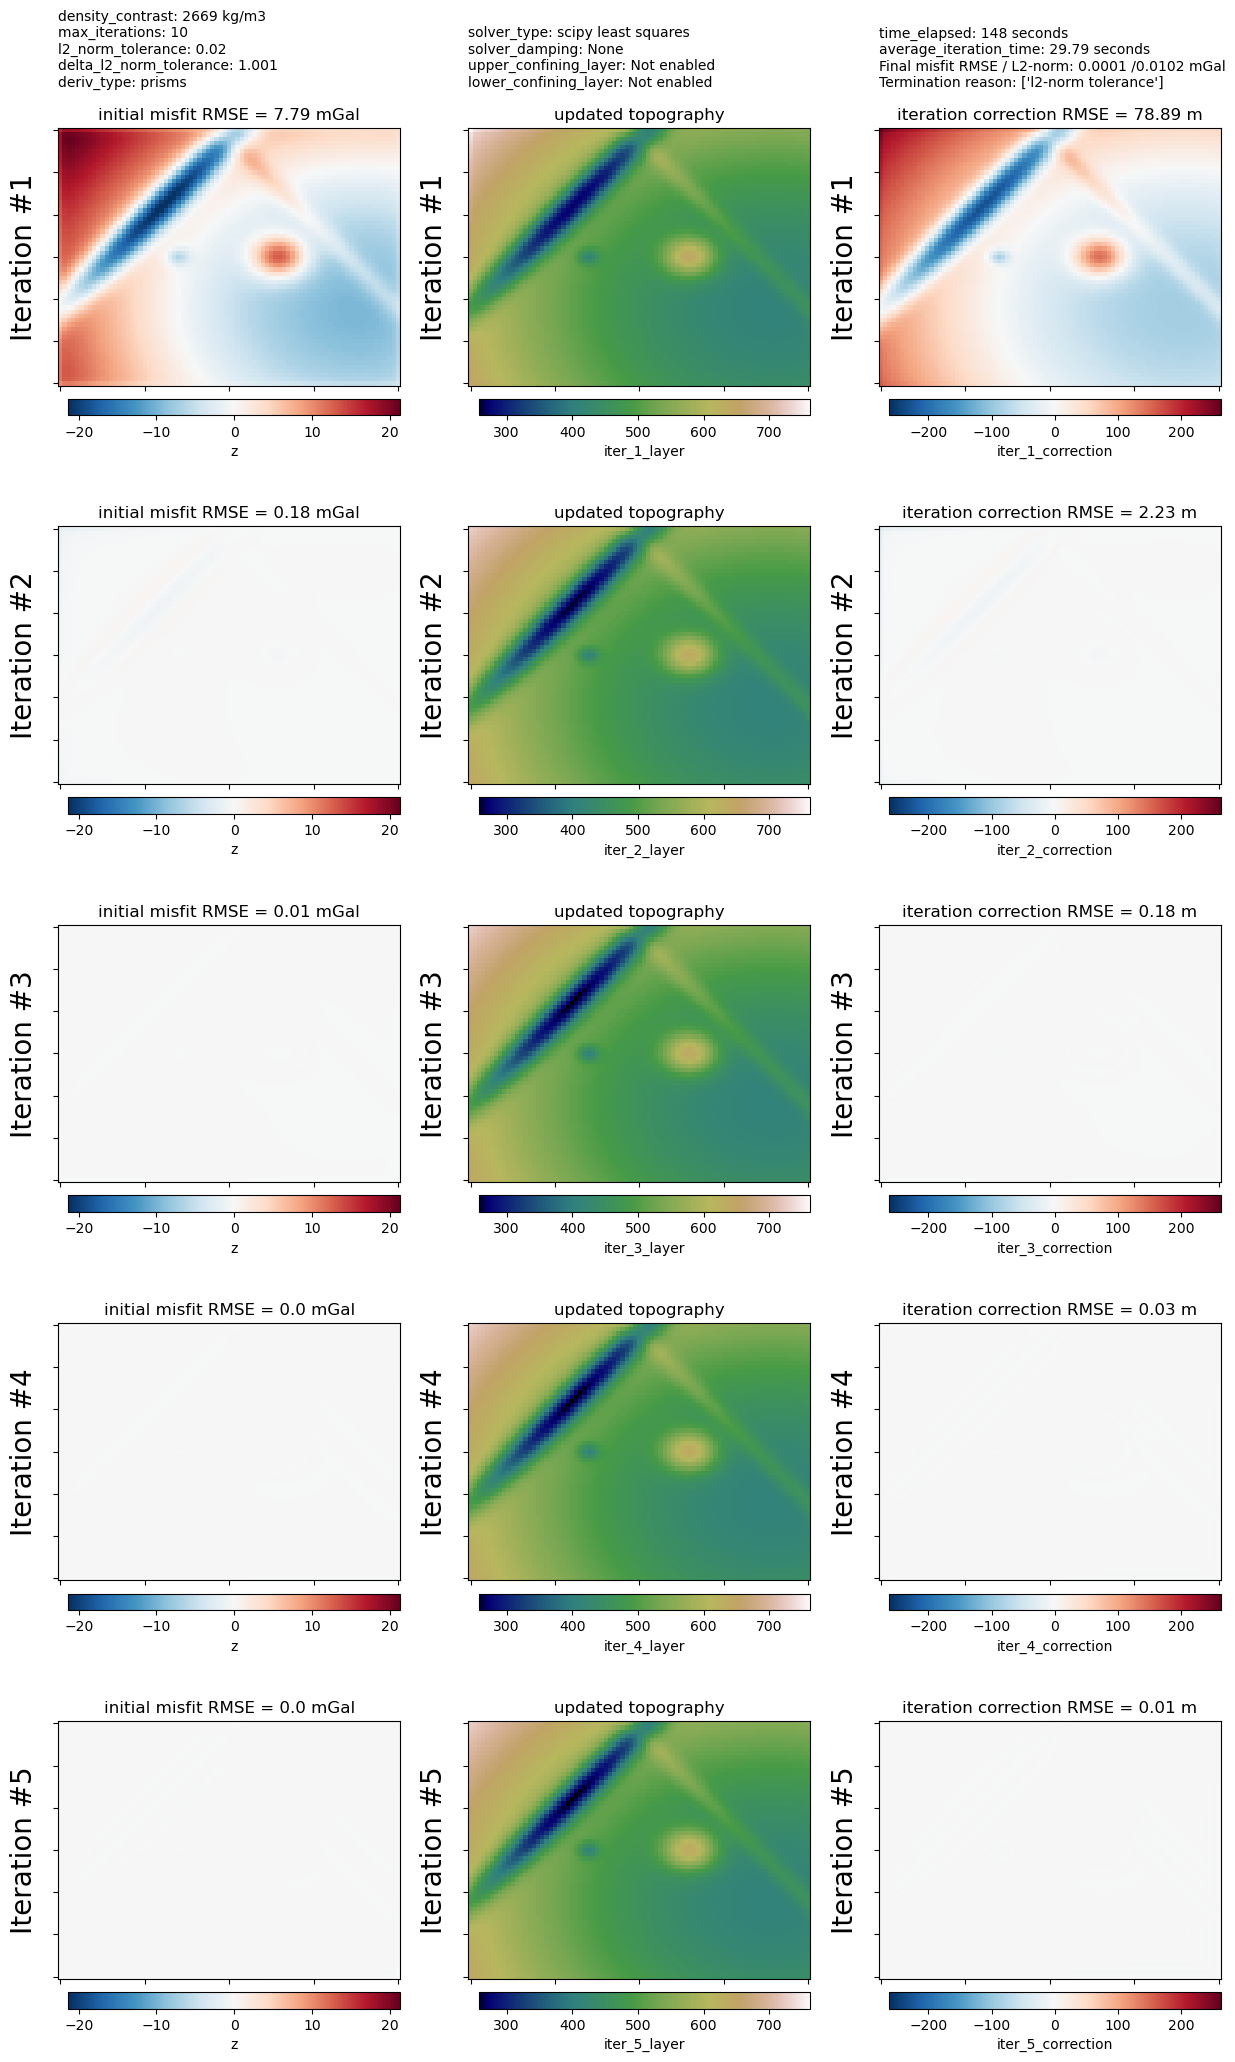

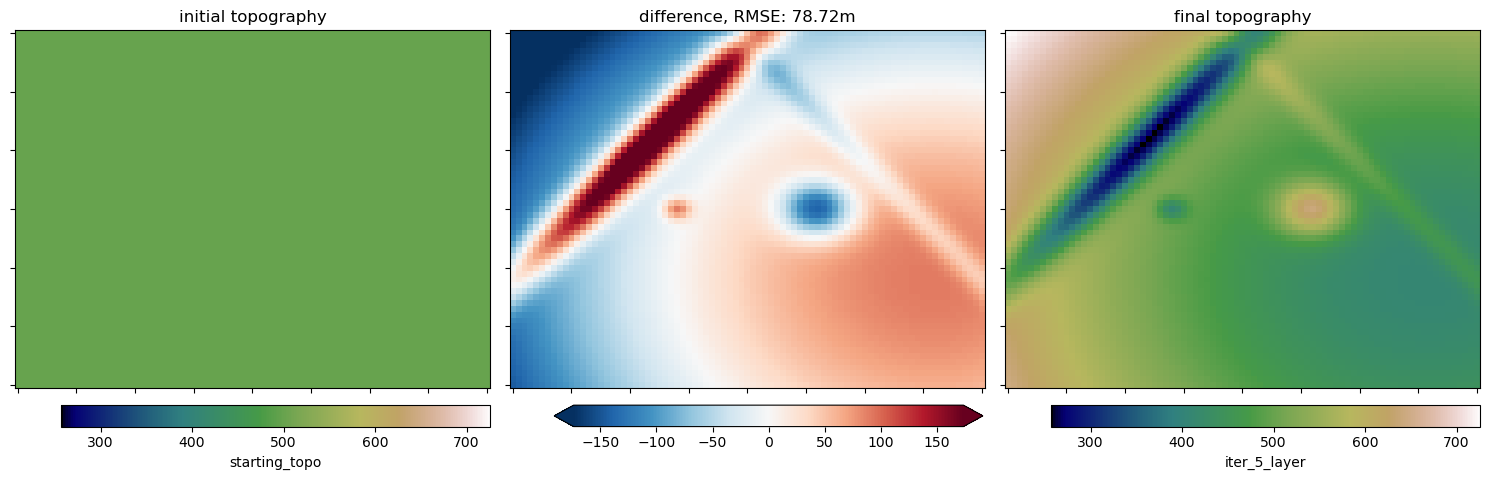

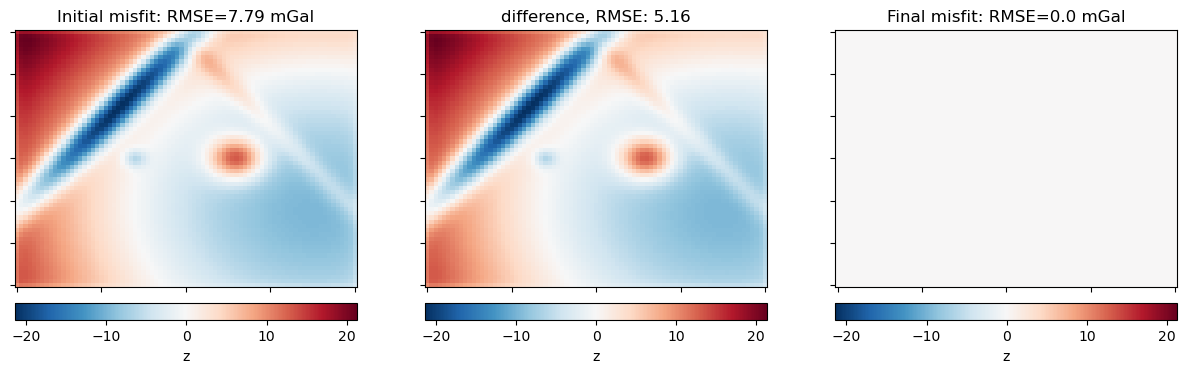

In [8]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


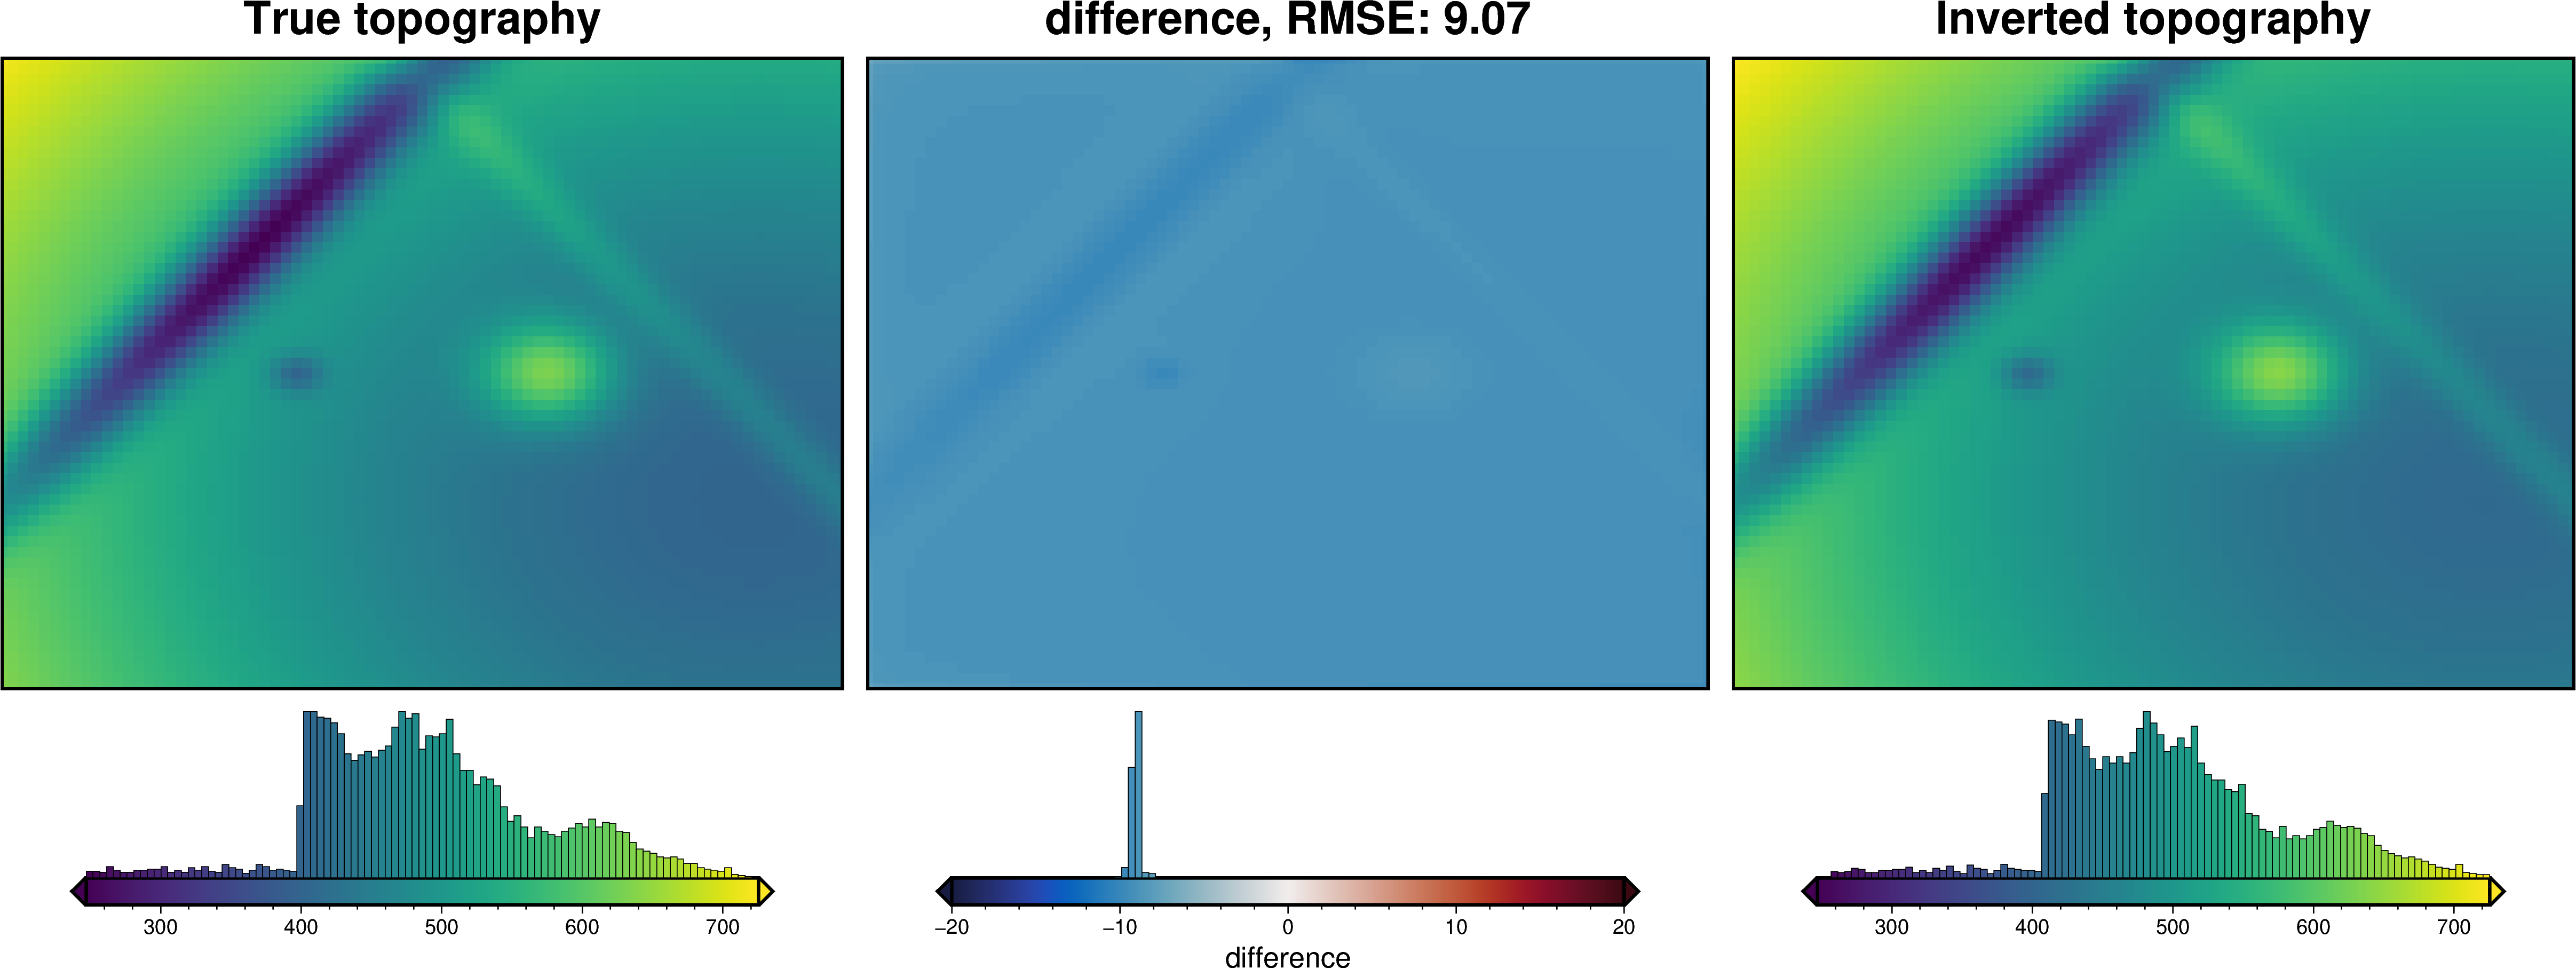

In [9]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    plot_type="pygmt",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    diff_lims=(-20, 20),
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered bathymetry was ~9 m. The inverted topography appears to be vertically shifted around 9 m lower than the true topography. This is likely due to the choice of the starting model elevation, which we arbitrary chose as 500 m. A later tutorial will explain how to pick the optimal value for the starting model height if you don't have any prior knowledge. 

#